In [1]:
import numpy as np
import os
import pickle
import scipy.io
from collections import OrderedDict, defaultdict, Counter, deque
import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib.patches import Patch

In [2]:
class EelEnv:
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.trial_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.mat')])
        self.current_trial_idx = -1
        self.trial_data = None
        self.total_reward = 0
        self.eels_info = []
        self.load_next_trial()

    def load_next_trial(self):
        self.current_trial_idx += 1
        if self.current_trial_idx >= len(self.trial_files):
            self.trial_data = None
            self.eels_info = []
            return False

        filepath = os.path.join(self.data_folder, self.trial_files[self.current_trial_idx])
        mat = scipy.io.loadmat(filepath, squeeze_me=True)
        curr_trial_data = mat['curr_trial_data']

        self.trial_data = curr_trial_data
        eel_field = curr_trial_data['eels']

        if isinstance(eel_field, np.ndarray) and eel_field.dtype == object:
            eel_tuples = eel_field.tolist()
        else:
            eel_tuples = [eel_field]

        self.eels_info = []
        for eel in eel_tuples:
            eel_dict = {
                'idx': eel[0],
                'side': eel[1],  # 1 = left, 2 = right
                'color': eel[2],
                'pos': eel[3],
                'fish_pos': eel[4],
                'potent': eel[5],
                'comp_change': eel[6],
                'dist_params': eel[7],
                'competency': eel[8],
                'final_competency': eel[9],
                'reliability': eel[10],
            }
            self.eels_info.append(eel_dict)
            
        return True
    
    def color_name(self, rgb):
        if list(rgb) == [0, 0, 255]:
            return "Blue"
        elif list(rgb) == [157, 0, 255]:
            return "Purple"
        else:
            return f"RGB{list(rgb)}"
    
    def step(self, action):
        if self.trial_data is None or not self.eels_info:
            return None, True, {}
        
        # Find index of left eel and right eel in eels_info
        left_idx = next(i for i, eel in enumerate(self.eels_info) if eel['side'] == 1)
        right_idx = next(i for i, eel in enumerate(self.eels_info) if eel['side'] == 2)

        # Map action 0 to left eel, 1 to right eel
        chosen_idx = left_idx if action == 0 else right_idx
        chosen_eel = self.eels_info[chosen_idx]

        # Print info of both eels
        left_eel = self.eels_info[left_idx]
        right_eel = self.eels_info[right_idx]
        
        #print(f"Trial {self.current_trial_idx + 1}:")
        #for i, eel in enumerate(self.eels_info):
            #side_str = 'left' if eel['side'] == 1 else 'right'
            #print(f"Eel {i} info:")
            #print(f"  Side: {side_str}")
            #print(f"  Color: {self.color_name(eel['color'])}")
            #print(f"  Competency: {eel['competency']:.3f}")
            #print(f"  Reliability: {eel['reliability']:.3f}")

        comp = chosen_eel['competency']
        prob_fish_caught = np.array([
            (1 - comp) ** 3,
            3 * comp * (1 - comp) ** 2,
            3 * comp ** 2 * (1 - comp),
            comp ** 3
        ])
        prob_fish_caught /= prob_fish_caught.sum()

        num_fish_caught = np.random.choice([0, 1, 2, 3], p=prob_fish_caught)
        reward_prob = chosen_eel['reliability'] * num_fish_caught
        reward = int(np.random.rand() < reward_prob)

        #print("---------------------------------------------------------")
        #print(f"Chosen eel side: {'left' if chosen_eel['side'] == 1 else 'right'}")
        #print(f"Chosen eel color: {self.color_name(chosen_eel['color'])}")
        #print(f"Number of fish caught: {num_fish_caught}")
        #print(f"Reward probability (reliability × fish caught): {reward_prob:.3f}")
        #print(f"Reward delivered: {reward}")
        #print("---------------------------------------------------------")
        #print(f"Cumulative reward: {self.total_reward + reward}\n")

        info = {
            'chosen_side': 'left' if chosen_eel['side'] == 1 else 'right',
            'eel_color': chosen_eel['color'],
            'competency': comp,
            'reliability': chosen_eel['reliability'],
            'num_fish_caught': num_fish_caught,
            'reward_prob': reward_prob
        }

        done = not self.load_next_trial()
        self.total_reward += reward

        return reward, done, info

In [3]:
class QLearningAgent:
    def __init__(self, n_actions=2, alpha=0.1, gamma=0.9, epsilon=0.7, max_q_entries=10):
        self.q_table = OrderedDict()  # keep insertion order for culling old states
        self.alpha = alpha            # learning rate
        self.gamma = gamma            # discount factor
        self.epsilon = epsilon        # exploration rate
        self.n_actions = n_actions
        self.max_q_entries = max_q_entries
        self.experience_buffer = []   # store transitions for batch update

    def _ensure_state_in_q_table(self, state_key):
        #Helper to ensure a state_key exists in q_table, culling if needed.
        if state_key not in self.q_table:
            if len(self.q_table) >= self.max_q_entries:
                # Remove the oldest entry if table is full
                self.q_table.popitem(last=False)
            self.q_table[state_key] = [0.0] * self.n_actions
        # If the state already exists, move it to the end to mark it as recently used
        else:
            # Reinsert to move it to the end (most recently used)
            # This is crucial for the OrderedDict's LRU-like behavior
            value = self.q_table.pop(state_key)
            self.q_table[state_key] = value

    def choose_action(self, state_key):
        # Ensure state_key exists in q_table before choosing an action
        self._ensure_state_in_q_table(state_key)

        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            return int(np.argmax(self.q_table[state_key]))

    def store_experience(self, state_key, action, reward, next_state_key):
        self.experience_buffer.append((state_key, action, reward, next_state_key))

    def update(self):
        for state_key, action, reward, next_state_key in self.experience_buffer:
            # Ensure both current and next states are in the Q-table
            self._ensure_state_in_q_table(state_key)
            if next_state_key is not None:
                self._ensure_state_in_q_table(next_state_key)

            old_value = self.q_table[state_key][action]
            next_max = max(self.q_table[next_state_key]) if next_state_key else 0.0

            # Q-learning update rule
            new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)
            self.q_table[state_key][action] = new_value

        self.experience_buffer.clear()

In [15]:
def save_checkpoint(agent, cumulative_rewards, trial_idx, episode_num):
    checkpoint_dir = "checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint = {
        'Q_table': agent.q_table,
        'cumulative_rewards': cumulative_rewards,
        'trial_idx': trial_idx,
        'episode_num': episode_num
    }

    filename = f"episode{episode_num}_trial{trial_idx}.pkl"
    save_path = os.path.join(checkpoint_dir, filename)
    with open(save_path, 'wb') as f:
        pickle.dump(checkpoint, f)

    print(f"[Checkpoint] Saved to {save_path}")

def load_checkpoint(agent, episode_num):
    checkpoint_dir = "checkpoints"
    prev_episode = episode_num - 1
    if prev_episode < 1:
        return [], 0  # No previous episode to load from

    checkpoint_file = os.path.join(checkpoint_dir, f"episode{prev_episode}_trial300.pkl")
    if not os.path.exists(checkpoint_file):
        print(f"[Checkpoint] No checkpoint found for episode {prev_episode}")
        return [], 0

    with open(checkpoint_file, 'rb') as f:
        checkpoint = pickle.load(f)
        agent.q_table = checkpoint.get('Q_table', {})
        cumulative_rewards = checkpoint.get('cumulative_rewards', [])
        trial_idx = checkpoint.get('trial_idx', 0)
        print(f"[Checkpoint] Loaded from {checkpoint_file}")
        return cumulative_rewards, trial_idx

In [23]:
train_log = {}
episode_num = 10
prev_episode = episode_num - 1 

env = EelEnv(data_folder=f'premade_eels/train/episode{episode_num}')
agent = QLearningAgent()

# Load checkpoint if available
cumulative_rewards, start_trial = load_checkpoint(agent, episode_num)

if prev_episode != episode_num:
    start_trial = 0

# === Episode-specific variables ===
trial_log = []  # Store (state, action, reward, color, side) per trial
cumulative_rewards = []  # Reset for this episode
total_reward = 0         # Reset total reward for episode

color_choices_per_bin = [] 
left_choices, right_choices = [], []
batch_transitions = []

for trial_idx in range(start_trial, len(env.trial_files)):
    
    left_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 1)
    right_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 2)

    state = (
        round(env.eels_info[left_idx]['competency'], 2),
        round(env.eels_info[left_idx]['reliability'], 2),
        round(env.eels_info[right_idx]['competency'], 2),
        round(env.eels_info[right_idx]['reliability'], 2),
    )

    action = agent.choose_action(state)
    reward, done, info = env.step(action)
    color = env.color_name(info['eel_color'])
    
    # Save to trial log
    trial_log.append((state, action, reward, color, info['chosen_side']))
    
    if not done:
        next_left_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 1)
        next_right_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 2)
        next_state = (
            round(env.eels_info[next_left_idx]['competency'], 2),
            round(env.eels_info[next_left_idx]['reliability'], 2),
            round(env.eels_info[next_right_idx]['competency'], 2),
            round(env.eels_info[next_right_idx]['reliability'], 2),
        )
    else:
        next_state = None
        
    # Store for batch update
    batch_transitions.append((state, action, reward, next_state))
    total_reward += reward

    # Count choices per 10-trial bin
    bin_idx = trial_idx // 10
    
    while len(color_choices_per_bin) <= bin_idx:
        color_choices_per_bin.append(defaultdict(int))
        
    color_choices_per_bin[bin_idx][color] += 1
    
    while len(left_choices) <= bin_idx:
        left_choices.append(0)
        right_choices.append(0)

    if action == 0:
        left_choices[bin_idx] += 1
    else:
        right_choices[bin_idx] += 1

    # Save cumulative reward per trial (not averaged)
    cumulative_rewards.append(total_reward)

    # Batch update every 10 trials or at last trial
    if (trial_idx + 1) % 10 == 0 or (trial_idx + 1) == len(env.trial_files):
        # Store experiences in the agent's buffer
        for s, a, r, s_next in batch_transitions:
            agent.store_experience(s, a, r, s_next)
    
        # Update Q-table in batch
        agent.update()
    
        batch_transitions = []  # Clear batch

        # Save checkpoint every batch update (optional, can save less frequently)
        save_checkpoint(agent, cumulative_rewards, trial_idx + 1, episode_num)

        
# === After the episode finishes ===
# Save the trial log for this episode
train_log[episode_num] = trial_log

# Save all logs to a .pkl file (append or update)
log_dir = "train_log"
os.makedirs(log_dir, exist_ok=True)
log_path = os.path.join(log_dir, f"episode{episode_num}_log.pkl")

# Load existing log if it exists
if os.path.exists(log_path):
    with open(log_path, 'rb') as f:
        existing_log = pickle.load(f)
else:
    existing_log = {}

# Update with current episode log
existing_log[episode_num] = trial_log

# Save back to file
with open(log_path, 'wb') as f:
    pickle.dump(existing_log, f)

[Checkpoint] Loaded from checkpoints\episode9_trial300.pkl
[Checkpoint] Saved to checkpoints\episode10_trial10.pkl
[Checkpoint] Saved to checkpoints\episode10_trial20.pkl
[Checkpoint] Saved to checkpoints\episode10_trial30.pkl
[Checkpoint] Saved to checkpoints\episode10_trial40.pkl
[Checkpoint] Saved to checkpoints\episode10_trial50.pkl
[Checkpoint] Saved to checkpoints\episode10_trial60.pkl
[Checkpoint] Saved to checkpoints\episode10_trial70.pkl
[Checkpoint] Saved to checkpoints\episode10_trial80.pkl
[Checkpoint] Saved to checkpoints\episode10_trial90.pkl
[Checkpoint] Saved to checkpoints\episode10_trial100.pkl
[Checkpoint] Saved to checkpoints\episode10_trial110.pkl
[Checkpoint] Saved to checkpoints\episode10_trial120.pkl
[Checkpoint] Saved to checkpoints\episode10_trial130.pkl
[Checkpoint] Saved to checkpoints\episode10_trial140.pkl
[Checkpoint] Saved to checkpoints\episode10_trial150.pkl
[Checkpoint] Saved to checkpoints\episode10_trial160.pkl
[Checkpoint] Saved to checkpoints\epis

In [18]:
import os
import pickle
from pprint import pprint # For pretty printing dictionaries/lists

def inspect_logs(log_dir, agent_type, start_episode=1, end_episode=10):
    """
    Inspects log files for a given agent type and episode range.
    """
    print(f"\n--- Inspecting {agent_type} Logs in '{log_dir}' ---")
    log_files_found = []
    prefix = ""
    if agent_type.lower() == "dqn":
        prefix = "dqn_" # Assuming DQN logs have a 'dqn_' prefix

    for ep_num in range(start_episode, end_episode + 1):
        log_filename = f"{prefix}episode{ep_num}_log.pkl"
        log_path = os.path.join(log_dir, log_filename)
        if os.path.exists(log_path):
            log_files_found.append((ep_num, log_path))
        else:
            print(f"  {log_filename} not found.")

    if not log_files_found:
        print(f"No {agent_type} log files found in the specified range and directory.")
        return

    print("\nFound log files:")
    for ep_num, path in log_files_found:
        print(f"  - Episode {ep_num}: {path}")

    while True:
        try:
            choice = input(f"\nEnter episode number to inspect (1-{end_episode}), 'all' to inspect all, or 'q' to quit: ").lower()
            if choice == 'q':
                break
            elif choice == 'all':
                episodes_to_inspect = [ep_num for ep_num, _ in log_files_found]
            else:
                episodes_to_inspect = [int(choice)]

            for ep_num in episodes_to_inspect:
                found_path = next((path for num, path in log_files_found if num == ep_num), None)
                if not found_path:
                    print(f"Episode {ep_num} not found. Please choose from the list above.")
                    continue

                print(f"\n--- Loading and inspecting {agent_type} Episode {ep_num} from '{found_path}' ---")
                try:
                    with open(found_path, 'rb') as f:
                        log_data = pickle.load(f)

                    # Handle Q-Learning specific loading (if it's a nested dict)
                    if agent_type.lower() == "q-learning" and isinstance(log_data, dict) and ep_num in log_data:
                        actual_episode_logs = log_data.get(ep_num, [])
                    else:
                        actual_episode_logs = log_data

                    if not actual_episode_logs:
                        print(f"  Episode {ep_num} log is empty or invalid.")
                        continue

                    print(f"  Total trials in Episode {ep_num}: {len(actual_episode_logs)}")
                    print("\n  Sample Trial Data (first 3 trials):")

                    for i, trial in enumerate(actual_episode_logs[:3]):
                        print(f"\n  --- Trial {i+1} ---")
                        if agent_type.lower() == "dqn":
                            if isinstance(trial, dict):
                                print("    Type: Dictionary (Expected for DQN)")
                                print("    Keys:", list(trial.keys()))
                                state = trial.get('state')
                                action = trial.get('action')
                                reward = trial.get('reward')
                                info = trial.get('info', {})
                                chosen_side = info.get('chosen_side')

                                print(f"    state (first 50 chars): {str(state)[:50]}...")
                                print(f"    action: {action}")
                                print(f"    reward: {reward}")
                                print(f"    info['chosen_side']: {chosen_side}")
                                if 'info' in trial:
                                    print("    Full 'info' dict:")
                                    pprint(info, indent=6)
                            else:
                                print(f"    WARNING: Unexpected trial format for DQN. Expected dict, got {type(trial)}")
                                pprint(trial, indent=4) # Show raw unexpected data
                        else: # Q-Learning
                            if isinstance(trial, (list, tuple)) and len(trial) >= 5:
                                print("    Type: Tuple/List (Expected for Q-Learning)")
                                # (state, action, reward, color, chosen_side)
                                state = trial[0]
                                action = trial[1]
                                reward = trial[2]
                                color_str = trial[3] # This is the string like "Blue"
                                chosen_side = trial[4] # This is the string 'left'/'right' or None

                                print(f"    state (first 50 chars): {str(state)[:50]}... (Expected 4 elements: compL, relL, compR, relR)")
                                print(f"      State Length: {len(state) if isinstance(state, (list,tuple)) else 'N/A'}")
                                print(f"    action: {action}")
                                print(f"    reward: {reward}")
                                print(f"    color (chosen eel string): {color_str}")
                                print(f"    chosen_side: {chosen_side}")
                            else:
                                print(f"    WARNING: Unexpected trial format for Q-Learning. Expected tuple/list with >=5 elements, got {type(trial)} with length {len(trial) if isinstance(trial, (list,tuple)) else 'N/A'}")
                                pprint(trial, indent=4) # Show raw unexpected data

                    if len(actual_episode_logs) > 3:
                        print(f"\n  ... (showing only first 3 of {len(actual_episode_logs)} trials)")

                except Exception as e:
                    print(f"  ERROR: Could not load/inspect Episode {ep_num}: {e}")
        except ValueError:
            print("Invalid input. Please enter a number, 'all', or 'q'.")

    print("\nLog inspection complete.")


if __name__ == "__main__":
    Q_LEARNING_LOG_DIR = "train_log"
    DQN_LOG_DIR = "dqn_train_logs"
    START_EP = 1
    END_EP = 10 # Adjust this to match your actual episode range

    print("Starting log inspection utility.")

    # Inspect Q-Learning logs
    inspect_logs(Q_LEARNING_LOG_DIR, "Q-Learning", START_EP, END_EP)

    # Inspect DQN logs
    inspect_logs(DQN_LOG_DIR, "DQN", START_EP, END_EP)


Starting log inspection utility.

--- Inspecting Q-Learning Logs in 'train_log' ---

Found log files:
  - Episode 1: train_log\episode1_log.pkl
  - Episode 2: train_log\episode2_log.pkl
  - Episode 3: train_log\episode3_log.pkl
  - Episode 4: train_log\episode4_log.pkl
  - Episode 5: train_log\episode5_log.pkl
  - Episode 6: train_log\episode6_log.pkl
  - Episode 7: train_log\episode7_log.pkl
  - Episode 8: train_log\episode8_log.pkl
  - Episode 9: train_log\episode9_log.pkl
  - Episode 10: train_log\episode10_log.pkl

Enter episode number to inspect (1-10), 'all' to inspect all, or 'q' to quit: 1

--- Loading and inspecting Q-Learning Episode 1 from 'train_log\episode1_log.pkl' ---
  Total trials in Episode 1: 300

  Sample Trial Data (first 3 trials):

  --- Trial 1 ---
    Type: Tuple/List (Expected for Q-Learning)
    state (first 50 chars): (0.7, 0.1, 0.9, 0.25)... (Expected 4 elements: compL, relL, compR, relR)
      State Length: 4
    action: 0
    reward: 0
    color (chosen e

KeyboardInterrupt: Interrupted by user

In [5]:
# ===== Plotting Section =====

# 1. Cumulative Reward Plot
plt.figure(figsize=(10, 4))
plt.plot(cumulative_rewards, label="Cumulative Reward")
plt.xlabel("Trial")
plt.ylabel("Cumulative Reward")
plt.title(f"Agent's Cumulative Reward - Episode {episode_num}")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

# 2. Choice Frequency Plot (per 10 trials)
x = np.arange(len(left_choices)) * 10  # trial bins
width = 4

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, left_choices, width=width, label='Left Eel')
plt.bar(x + width/2, right_choices, width=width, label='Right Eel')
plt.xlabel("Trial Bin (every 10 trials)")
plt.ylabel("Choices")
plt.title("Eel Choices by 10-Trial Batches")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# 3. Color coded Plot 
# Collect unique colors (sorted for consistent order)
all_colors = sorted(set(color for counter in color_choices_per_bin for color in counter))
num_colors = len(all_colors)
num_bins = len(color_choices_per_bin)
x = np.arange(num_bins) * 10  # trial bins

width = 4  # Same as in your left/right plot
total_width = width * num_colors
bar_spacing = width  # spacing between color bars

plt.figure(figsize=(10,4))

# Each color gets its own offset in the bin
for i, color in enumerate(all_colors):
    counts = [counter.get(color, 0) for counter in color_choices_per_bin]
    offsets = x - (total_width / 2) + (i + 0.5) * bar_spacing
    plt.bar(offsets, counts, width=bar_spacing * 0.9, label=color)  # slight shrink for spacing

plt.xlabel("Trial Bin (every 10 trials)")
plt.ylabel("Color Choices")
plt.title("Eel Color Choices by 10-Trial Batches")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

NameError: name 'cumulative_rewards' is not defined

<Figure size 1000x400 with 0 Axes>

In [16]:
def load_all_episode_logs(log_dir="train_log", start_episode=1, end_episode=10):
    """
    Loads trial logs for all episodes within the specified range.

    Args:
        log_dir (str): Directory where episode logs are saved.
        start_episode (int): The first episode number to load.
        end_episode (int): The last episode number to load.

    Returns:
        dict: A dictionary where keys are episode numbers and values are
              the list of trial logs for that episode.
              Example: {1: [(state, action, reward, ...), ...], 2: [...], ...}
    """
    all_logs = {}
    for ep_num in range(start_episode, end_episode + 1):
        log_path = os.path.join(log_dir, f"episode{ep_num}_log.pkl")
        if os.path.exists(log_path):
            try:
                with open(log_path, 'rb') as f:
                    episode_data = pickle.load(f)
                    # The saved pickle might contain a dictionary of episode numbers
                    # if existing_log is updated with existing_log[episode_num] = trial_log
                    # We want the specific trial_log for this ep_num
                    if isinstance(episode_data, dict) and ep_num in episode_data:
                        all_logs[ep_num] = episode_data.get(ep_num) # Use .get to safely handle if key not present
                        if all_logs[ep_num] is None:
                            print(f"Warning: Episode {ep_num} found in log file but data is None.")
                    else:
                        print(f"Warning: Log for episode {ep_num} not in expected dictionary format. Attempting direct load.")
                        all_logs[ep_num] = episode_data # Assume it's directly the list of logs
            except Exception as e:
                print(f"Error loading log for episode {ep_num}: {e}")
        # else: # Uncomment for debugging if you expect specific files
        #     print(f"Log file not found for episode {ep_num}: {log_path}")
    return all_logs

## DQN

In [12]:
# --- Neural Network for Q-Function Approximation ---
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [13]:
# --- Experience Replay Buffer ---
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [14]:
# --- DQN Agent Class ---
class DQNAgent:
    def __init__(self, state_size, action_size, seed,
                 buffer_size=int(1e5), batch_size=64, gamma=0.99, lr=5e-4,
                 update_every=4, target_update_freq=100):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.gamma = gamma
        self.lr = lr
        self.update_every = update_every
        self.target_update_freq = target_update_freq

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(self.device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.lr)

        self.memory = ReplayBuffer(buffer_size, batch_size, seed)
        self.t_step = 0

        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.memory.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

        # Update target network
        if (self.t_step + self.memory.batch_size) % self.target_update_freq == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())


    def choose_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() > self.epsilon:
            return np.argmax(action_values.cpu().data.numpy()).item()
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


    def save_checkpoint(self, path):
        """Saves the agent's models and epsilon state."""
        torch.save({
            'qnetwork_local_state_dict': self.qnetwork_local.state_dict(),
            'qnetwork_target_state_dict': self.qnetwork_target.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            't_step': self.t_step
        }, path)

    def load_checkpoint(self, path):
        """Loads the agent's models and epsilon state from a checkpoint."""
        if os.path.exists(path):
            checkpoint = torch.load(path, map_location=self.device)
            self.qnetwork_local.load_state_dict(checkpoint['qnetwork_local_state_dict'])
            self.qnetwork_target.load_state_dict(checkpoint['qnetwork_target_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.epsilon = checkpoint['epsilon']
            self.t_step = checkpoint['t_step']
            return True
        return False

In [15]:
# --- Main Training Loop for DQN Agent ---
def train_dqn_agent(num_episodes, data_folder_prefix,
                    checkpoint_dir="dqn_checkpoints", log_dir="dqn_train_logs",
                    state_size=4, action_size=2, seed=0,
                    buffer_size=int(1e3), batch_size=8, gamma=0.99, lr=5e-4,
                    update_every=4, target_update_freq=100):
    
    # Create distinct directories for DQN results
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(log_dir, exist_ok=True)

    # Initialize DQN Agent
    agent = DQNAgent(state_size, action_size, seed, buffer_size, batch_size, gamma, lr, update_every, target_update_freq)

    print(f"DQN Training initiated. Saving checkpoints to '{checkpoint_dir}' and logs to '{log_dir}'.")

    for episode_num in range(1, num_episodes + 1):
        print(f"\n--- Starting DQN Training for Episode {episode_num} ---")
        
        # Determine data folder for current episode
        current_data_folder = f"{data_folder_prefix}/episode{episode_num}"
        
        # Initialize environment for the current episode
        try:
            env = EelEnv(data_folder=current_data_folder)
        except FileNotFoundError as e:
            print(f"Skipping episode {episode_num}: {e}")
            continue

        # Reset episode-specific metrics for tracking current episode's performance
        total_reward_current_episode = 0
        trial_log_current_episode = [] # To store details per trial for this episode

        done = False
        trial_idx = 0

        # Loop through trials within the current episode
        while not done:
            trial_idx += 1
            
            # Check if current trial data is valid before processing
            if not env.eels_info:
                print(f"  No eel info loaded for trial {trial_idx} in episode {episode_num}, ending episode prematurely.")
                done = True
                break

            left_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 1)
            right_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 2)

            current_state_array = np.array([
                env.eels_info[left_idx]['competency'],
                env.eels_info[left_idx]['reliability'],
                env.eels_info[right_idx]['competency'],
                env.eels_info[right_idx]['reliability'],
            ], dtype=np.float32)

            action = agent.choose_action(current_state_array)

            reward, done, info = env.step(action)
            total_reward_current_episode += reward

            if not done:
                next_left_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 1)
                next_right_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 2)
                next_state_array = np.array([
                    env.eels_info[next_left_idx]['competency'],
                    env.eels_info[next_left_idx]['reliability'],
                    env.eels_info[next_right_idx]['competency'],
                    env.eels_info[next_right_idx]['reliability'],
                ], dtype=np.float32)
            else:
                next_state_array = np.zeros(state_size, dtype=np.float32)
            
            agent.step(current_state_array, action, reward, next_state_array, done)

            trial_log_current_episode.append({
                'state': current_state_array.tolist(),
                'action': action,
                'reward': reward,
                'chosen_side': info['chosen_side'],
                'eel_color': env.color_name(info['eel_color']),
                'competency': info['competency'],
                'reliability': info['reliability'],
                'num_fish_caught': info['num_fish_caught'],
                'reward_prob': info['reward_prob']
            })

        print(f"Episode {episode_num} finished. Total Reward: {total_reward_current_episode:.2f}, Epsilon: {agent.epsilon:.4f}")

        agent.save_checkpoint(os.path.join(checkpoint_dir, f'dqn_episode{episode_num}.pth'))

        log_path = os.path.join(log_dir, f"dqn_episode{episode_num}_log.pkl")
        with open(log_path, 'wb') as f:
            pickle.dump(trial_log_current_episode, f)

    print("\nDQN Training Complete.")

In [18]:
# --- 1. Functions to Load Logs ---

def load_q_learning_logs(log_dir="train_log", start_episode=1, end_episode=10):
    """
    Loads trial logs for the original Q-learning agent.
    Assumes logs are lists of tuples: (state, action, reward, color, chosen_side)
    """
    all_logs = {}
    for ep_num in range(start_episode, end_episode + 1):
        log_path = os.path.join(log_dir, f"episode{ep_num}_log.pkl")
        if os.path.exists(log_path):
            try:
                with open(log_path, 'rb') as f:
                    episode_data = pickle.load(f)
                    # Original Q-learning log could be nested {ep_num: [trials]}
                    if isinstance(episode_data, dict) and ep_num in episode_data:
                        all_logs[ep_num] = episode_data.get(ep_num)
                    else:
                        all_logs[ep_num] = episode_data # Assume it's directly the list of logs
            except Exception as e:
                print(f"Error loading Q-Learning log for episode {ep_num}: {e}")
        else:
            print(f"Q-Learning log file not found for episode {ep_num}: {log_path}")
    return all_logs

def load_dqn_logs(log_dir="dqn_train_logs", start_episode=1, end_episode=10):
    """
    Loads trial logs for the DQN agent.
    Assumes logs are lists of dictionaries: {'state': [...], 'action': ..., 'reward': ...}
    """
    all_logs = {}
    for ep_num in range(start_episode, end_episode + 1):
        log_path = os.path.join(log_dir, f"dqn_episode{ep_num}_log.pkl")
        if os.path.exists(log_path):
            try:
                with open(log_path, 'rb') as f:
                    episode_data = pickle.load(f)
                    # DQN log is saved as a direct list of dictionaries for the episode
                    all_logs[ep_num] = episode_data
            except Exception as e:
                print(f"Error loading DQN log for episode {ep_num}: {e}")
        else:
            print(f"DQN log file not found for episode {ep_num}: {log_path}")
    return all_logs

# --- 2. Plotting Comparison Function ---

def plot_agent_comparison_rewards(q_learning_logs, dqn_logs, title="Q-learning vs. DQN"):
    """
    Plots the total cumulative reward for Q-Learning and DQN agents on the same graph.
    The plot will be saved as 'reward_comparison.svg'.

    Args:
        q_learning_logs (dict): Dictionary of loaded Q-Learning episode logs.
        dqn_logs (dict): Dictionary of loaded DQN episode logs.
        title (str): Title for the plot.
    """
    q_episode_numbers = sorted(q_learning_logs.keys())
    q_final_cumulative_rewards = []
    for ep_num in q_episode_numbers:
        trial_log = q_learning_logs.get(ep_num)
        if not trial_log:
            q_final_cumulative_rewards.append(0)
            continue
        current_cumulative_reward = 0
        # Original Q-learning log format is (state, action, reward, ...)
        for _, _, reward, _, _ in trial_log:
            current_cumulative_reward += reward
        q_final_cumulative_rewards.append(current_cumulative_reward)

    dqn_episode_numbers = sorted(dqn_logs.keys())
    dqn_final_cumulative_rewards = []
    for ep_num in dqn_episode_numbers:
        trial_log = dqn_logs.get(ep_num)
        if not trial_log:
            dqn_final_cumulative_rewards.append(0)
            continue
        current_cumulative_reward = 0
        # DQN log format is a list of dictionaries {'reward': ...}
        for trial_details in trial_log:
            current_cumulative_reward += trial_details['reward']
        dqn_final_cumulative_rewards.append(current_cumulative_reward)

    plt.figure(figsize=(14, 8))

    if q_episode_numbers:
        plt.plot(q_episode_numbers, q_final_cumulative_rewards, marker='o', linestyle='-', color='blue', label='Q-Learning Agent')
    else:
        print("Warning: No Q-Learning logs found to plot.")

    if dqn_episode_numbers:
        plt.plot(dqn_episode_numbers, dqn_final_cumulative_rewards, marker='x', linestyle='--', color='red', label='DQN Agent')
    else:
        print("Warning: No DQN logs found to plot.")

    plt.title(title, fontsize=18)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Cumulative Reward', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Ensure x-ticks cover the full range of both agents' episodes
    all_episode_numbers = sorted(list(set(q_episode_numbers + dqn_episode_numbers)))
    if all_episode_numbers:
        plt.xticks(all_episode_numbers)

    plt.legend(fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tight_layout()

    # Save the plot as an SVG file
    output_filename = "JHL_reward.svg" # You can change this name
    plt.savefig(output_filename, format='svg')
    print(f"Plot saved to {output_filename}")
    plt.close() # Close the plot figure to free up memory

# --- Main Execution Block ---
if __name__ == "__main__":
    # Define the range of episodes you trained for BOTH agents
    # Make sure these ranges match your actual generated log files
    ANALYSIS_START_EPISODE = 1
    ANALYSIS_END_EPISODE = 10 # Assuming both agents trained up to episode 10

    # Load logs for the original Q-Learning agent
    print(f"Loading Q-Learning logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    q_learning_logs = load_q_learning_logs(
        log_dir="train_log", # Your original Q-Learning log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded Q-Learning logs for {len(q_learning_logs)} episodes.")

    # Load logs for the DQN agent
    print(f"Loading DQN logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    dqn_logs = load_dqn_logs(
        log_dir="dqn_train_logs", # Your new DQN log directory
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded DQN logs for {len(dqn_logs)} episodes.")

    # Plot the comparison
    plot_agent_comparison_rewards(q_learning_logs, dqn_logs)

Loading Q-Learning logs from episode 1 to 10...
Loaded Q-Learning logs for 10 episodes.
Loading DQN logs from episode 1 to 10...
Loaded DQN logs for 10 episodes.
Plot saved to JHL_reward.svg


In [8]:
# --- YOUR ACTUAL CONSTANTS AND FUNCTIONS ---
# These are the correct RGB values based on your `color_name` method.
BLUE_RGB = (0, 0, 255)
PURPLE_RGB = (157, 0, 255)

def get_eel_info_from_state(state_tuple):
    """
    Your actual get_eel_info_from_state function.
    (Assuming it takes a 6-element state tuple and returns eel info dictionary)
    """
    if not isinstance(state_tuple, (tuple, list)) or len(state_tuple) != 6:
        raise ValueError(f"Invalid state_tuple format for get_eel_info_from_state: {state_tuple}")

    left_comp, left_rel, right_comp, right_rel, left_color_rgb, right_color_rgb = state_tuple
    
    return {
        'left': {'comp': left_comp, 'rel': left_rel, 'color': left_color_rgb},
        'right': {'comp': right_comp, 'rel': right_rel, 'color': right_color_rgb}
    }
# --- END YOUR ACTUAL CONSTANTS AND FUNCTIONS ---


# --- Functions to Load Logs (no change) ---
def load_q_learning_logs(log_dir="train_log", start_episode=1, end_episode=10):
    all_logs = {}
    for ep_num in range(start_episode, end_episode + 1):
        log_path = os.path.join(log_dir, f"episode{ep_num}_log.pkl")
        if os.path.exists(log_path):
            try:
                with open(log_path, 'rb') as f:
                    episode_data = pickle.load(f)
                    if isinstance(episode_data, dict) and ep_num in episode_data:
                        all_logs[ep_num] = episode_data.get(ep_num)
                    else:
                        all_logs[ep_num] = episode_data
            except Exception as e:
                print(f"Error loading Q-Learning log for episode {ep_num}: {e}")
        else:
            print(f"Q-Learning log file not found for episode {ep_num}: {log_path}")
    return all_logs

def load_dqn_logs(log_dir="dqn_train_logs", start_episode=1, end_episode=10):
    all_logs = {}
    for ep_num in range(start_episode, end_episode + 1):
        log_path = os.path.join(log_dir, f"dqn_episode{ep_num}_log.pkl")
        if os.path.exists(log_path):
            try:
                with open(log_path, 'rb') as f:
                    episode_data = pickle.load(f)
                    all_logs[ep_num] = episode_data
            except Exception as e:
                print(f"Error loading DQN log for episode {ep_num}: {e}")
        else:
            print(f"DQN log file not found for episode {ep_num}: {log_path}")
    return all_logs


# --- prepare_psychometric_data (no change, as it already compares lists) ---
def prepare_psychometric_data(episode_logs, agent_type="DQN", num_bins=20):
    is_dqn_log = (agent_type.lower() == "dqn")

    all_comp_diffs_bp = [] # Blue - Purple
    all_rel_diffs_bp = []  # Blue - Purple
    all_chose_blue = []    # 1 if agent chose Blue, 0 if chose Purple

    logs_to_process = []
    if isinstance(episode_logs, dict): # Processing multiple episodes for overall
        for ep_num in sorted(episode_logs.keys()):
            logs_to_process.extend(episode_logs.get(ep_num, []))
    elif isinstance(episode_logs, list): # Processing a single episode's list of trials
        logs_to_process = episode_logs

    if not logs_to_process:
        print(f"DEBUG: No logs to process for {agent_type} in prepare_psychometric_data.")
        return None, None, None, None

    for i, trial_data in enumerate(logs_to_process):
        state_raw_4_elements = None
        action = None
        chosen_side = None
        chosen_color_string = None
        state_to_process = None

        if is_dqn_log:
            if not isinstance(trial_data, dict):
                print(f"  ERROR: DQN trial {i+1} has unexpected format. Expected dict. Skipping. Data: {trial_data}")
                continue
            state_raw_4_elements = trial_data.get('state')
            action = trial_data.get('action')
            chosen_side = trial_data.get('chosen_side')
            chosen_color_string = trial_data.get('eel_color')
        else: # Q-Learning
            if not isinstance(trial_data, (tuple, list)) or len(trial_data) < 5:
                print(f"  ERROR: Q-Learning trial {i+1} has unexpected format. Expected tuple/list of at least 5 elements. Skipping. Data: {trial_data}")
                continue
            state_raw_4_elements = trial_data[0]
            action = trial_data[1]
            chosen_color_string = trial_data[3]
            chosen_side = trial_data[4]

        # --- COMMON INFERENCE LOGIC ---
        if not isinstance(state_raw_4_elements, (tuple, list)) or len(state_raw_4_elements) != 4:
            print(f"  ERROR: {agent_type} trial {i+1} state_raw_4_elements has unexpected format. Expected 4 elements. Skipping. Data: {state_raw_4_elements}")
            continue

        left_comp, left_rel, right_comp, right_rel = state_raw_4_elements
        left_color_rgb = None
        right_color_rgb = None

        if chosen_side not in ['left', 'right'] or chosen_color_string not in ["Blue", "Purple"]:
            print(f"  ERROR: {agent_type} trial {i+1} has invalid chosen_side ('{chosen_side}') or chosen_color_string ('{chosen_color_string}'). Cannot infer full state. Skipping.")
            continue

        if chosen_side == 'left':
            if chosen_color_string == "Blue":
                left_color_rgb = BLUE_RGB
                right_color_rgb = PURPLE_RGB
            elif chosen_color_string == "Purple":
                left_color_rgb = PURPLE_RGB
                right_color_rgb = BLUE_RGB
        elif chosen_side == 'right':
            if chosen_color_string == "Blue":
                right_color_rgb = BLUE_RGB
                left_color_rgb = PURPLE_RGB
            elif chosen_color_string == "Purple":
                right_color_rgb = PURPLE_RGB
                left_color_rgb = BLUE_RGB

        if left_color_rgb is None or right_color_rgb is None:
             print(f"  ERROR: {agent_type} trial {i+1} could not infer eel colors despite valid input. Chosen color: '{chosen_color_string}', Chosen side: '{chosen_side}'. Skipping.")
             continue

        state_to_process = (left_comp, left_rel, right_comp, right_rel,
                            tuple(left_color_rgb), tuple(right_color_rgb))

        if state_to_process is None or action is None or chosen_side is None:
            print(f"  DEBUG: Trial {i+1} skipped late: Missing reconstructed state, action, or chosen_side (unhandled error). State: {state_to_process}, Action: {action}, Chosen Side: {chosen_side}")
            continue

        try:
            eel_info_sides = get_eel_info_from_state(state_to_process)
        except ValueError as e:
            print(f"  ERROR: Skipping trial {i+1} due to invalid state format from get_eel_info_from_state: {e}. State data was: {state_to_process}")
            continue

        blue_eel_comp = None
        blue_eel_rel = None
        purple_eel_comp = None
        purple_eel_rel = None

        # Ensure consistent comparison (tuple vs list) for RGB values
        if list(eel_info_sides['left']['color']) == list(BLUE_RGB):
            blue_eel_comp = eel_info_sides['left']['comp']
            blue_eel_rel = eel_info_sides['left']['rel']
            purple_eel_comp = eel_info_sides['right']['comp']
            purple_eel_rel = eel_info_sides['right']['rel']
        elif list(eel_info_sides['right']['color']) == list(BLUE_RGB):
            blue_eel_comp = eel_info_sides['right']['comp']
            blue_eel_rel = eel_info_sides['right']['rel']
            purple_eel_comp = eel_info_sides['left']['comp']
            purple_eel_rel = eel_info_sides['left']['rel']
        else:
            print(f"  ERROR: Skipping trial {i+1}: Neither eel found to be Blue or Purple based on inferred/raw RGB. Colors: Left={eel_info_sides['left']['color']}, Right={eel_info_sides['right']['color']}. Please check BLUE_RGB/PURPLE_RGB constants.")
            continue


        all_comp_diffs_bp.append(blue_eel_comp - purple_eel_comp)
        all_rel_diffs_bp.append(blue_eel_rel - purple_eel_rel)

        if (chosen_side == 'left' and list(eel_info_sides['left']['color']) == list(BLUE_RGB)) or \
           (chosen_side == 'right' and list(eel_info_sides['right']['color']) == list(BLUE_RGB)):
            all_chose_blue.append(1)
        else:
            all_chose_blue.append(0)

    if not all_comp_diffs_bp:
        print(f"DEBUG: After processing all trials, all_comp_diffs_bp is empty for {agent_type}. No data to plot.")
        return None, None, None, None

    #print(f"\n--- DEBUG RAW DIFFERENCES FOR {agent_type} ({len(all_comp_diffs_bp)} trials) ---")
    #print(f"  Raw Competency Diffs (first 10 of {len(all_comp_diffs_bp)}): {all_comp_diffs_bp[:10]}")
    #print(f"  Unique Competency Diffs and Counts: {Counter(all_comp_diffs_bp)}")

    #print(f"  Raw Reliability Diffs (first 10 of {len(all_rel_diffs_bp)}): {all_rel_diffs_bp[:10]}")
    #print(f"  Unique Reliability Diffs and Counts: {Counter(all_rel_diffs_bp)}")
    #print(f"--- END RAW DIFFERENCES DEBUG ---\n")

    def bin_data(diffs, choices):
        if not diffs: return [], []
        bins = np.linspace(-1.0, 1.0, num_bins + 1)
        
        diffs_array = np.array(diffs)
        
        valid_indices = (diffs_array >= bins.min()) & (diffs_array <= bins.max())
        diffs_array_valid = diffs_array[valid_indices]
        choices_array_valid = np.array(choices)[valid_indices]

        if len(diffs_array_valid) == 0:
            return [], []

        bin_indices = np.digitize(diffs_array_valid, bins)

        binned_x = []
        binned_y = []
        for j in range(1, num_bins + 1):
            indices_in_bin = np.where(bin_indices == j)[0]
            if len(indices_in_bin) > 0:
                avg_diff = np.mean(diffs_array_valid[indices_in_bin])
                prob_choice = np.mean(choices_array_valid[indices_in_bin])
                binned_x.append(avg_diff)
                binned_y.append(prob_choice)

        if binned_x:
            binned_x, binned_y = zip(*sorted(zip(binned_x, binned_y)))
        return list(binned_x), list(binned_y)

    binned_comp_x, binned_comp_y = bin_data(all_comp_diffs_bp, all_chose_blue)
    binned_rel_x, binned_rel_y = bin_data(all_rel_diffs_bp, all_chose_blue)

    return binned_comp_x, binned_comp_y, binned_rel_x, binned_rel_y


# --- Consolidated Plotting Function for Psychometric Comparison (MODIFIED to save SVG) ---
def plot_compare_psychometric_functions_with_episodes(q_learning_logs, dqn_logs, num_bins=20, output_filename="psychometric_comparison.svg"):
    fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

    # --- Q-Learning Agent Plotting (Blue shades) ---
    for ep_num, trial_log in q_learning_logs.items():
        comp_x_ep, comp_y_ep, rel_x_ep, rel_y_ep = prepare_psychometric_data(trial_log, agent_type="Q-Learning", num_bins=num_bins)
        if comp_x_ep and comp_y_ep:
            axs[0].plot(comp_x_ep, comp_y_ep, color='skyblue', linestyle='-', linewidth=1.0, alpha=0.6)
        if rel_x_ep and rel_y_ep:
            axs[1].plot(rel_x_ep, rel_y_ep, color='skyblue', linestyle='-', linewidth=1.0, alpha=0.6)

    q_comp_x_overall, q_comp_y_overall, q_rel_x_overall, q_rel_y_overall = prepare_psychometric_data(q_learning_logs, agent_type="Q-Learning", num_bins=num_bins)
    if q_comp_x_overall:
        axs[0].plot(q_comp_x_overall, q_comp_y_overall, color='blue', linestyle='-', linewidth=2.5, label='Q-Learning Overall Trend')
        axs[0].scatter(q_comp_x_overall, q_comp_y_overall, color='blue', marker='o', s=50, zorder=3)
    else:
        print("Warning: No overall Q-Learning competency data to plot.")
    if q_rel_x_overall:
        axs[1].plot(q_rel_x_overall, q_rel_y_overall, color='blue', linestyle='-', linewidth=2.5, label='Q-Learning Overall Trend')
        axs[1].scatter(q_rel_x_overall, q_rel_y_overall, color='blue', marker='o', s=50, zorder=3)
    else:
        print("Warning: No overall Q-Learning reliability data to plot.")

    # --- DQN Agent Plotting (Red shades) ---
    for ep_num, trial_log in dqn_logs.items():
        comp_x_ep, comp_y_ep, rel_x_ep, rel_y_ep = prepare_psychometric_data(trial_log, agent_type="DQN", num_bins=num_bins)
        if comp_x_ep and comp_y_ep:
            axs[0].plot(comp_x_ep, comp_y_ep, color='lightcoral', linestyle='--', linewidth=1.0, alpha=0.6)
        if rel_x_ep and rel_y_ep:
            axs[1].plot(rel_x_ep, rel_y_ep, color='lightcoral', linestyle='--', linewidth=1.0, alpha=0.6)

    dqn_comp_x_overall, dqn_comp_y_overall, dqn_rel_x_overall, dqn_rel_y_overall = prepare_psychometric_data(dqn_logs, agent_type="DQN", num_bins=num_bins)
    if dqn_comp_x_overall:
        axs[0].plot(dqn_comp_x_overall, dqn_comp_y_overall, color='red', linestyle='--', linewidth=2.5, label='DQN Overall Trend')
        axs[0].scatter(dqn_comp_x_overall, dqn_comp_y_overall, color='red', marker='x', s=50, zorder=3)
    else:
        print("Warning: No overall DQN competency data to plot.")
    if dqn_rel_x_overall:
        axs[1].plot(dqn_rel_x_overall, dqn_rel_y_overall, color='red', linestyle='--', linewidth=2.5, label='DQN Overall Trend')
        axs[1].scatter(dqn_rel_x_overall, dqn_rel_y_overall, color='red', marker='x', s=50, zorder=3)
    else:
        print("Warning: No overall DQN reliability data to plot.")

    # --- Common Plot Settings ---
    axs[0].set_title(r'$\Delta$ Competency', fontsize=14)
    axs[0].set_xlabel(r'$\Delta$ Competency (Blue - Purple)', fontsize=12)
    axs[0].set_ylabel(r'P(Choice = Blue)', fontsize=12)
    axs[0].set_xlim(-1.05, 1.05)
    axs[0].set_ylim(-0.05, 1.05)
    axs[0].axvline(0, color='grey', linestyle='--', alpha=0.7)
    axs[0].axhline(0.5, color='grey', linestyle='--', alpha=0.7)
    axs[0].grid(True, linestyle=':', alpha=0.6)

    competency_legend_handles = [
        Line2D([0], [0], color='blue', linestyle='-', linewidth=2.5, label='Q-Learning Overall Trend', marker='o', markersize=6),
        Line2D([0], [0], color='skyblue', linestyle='-', linewidth=1.0, alpha=0.7, label='Q-Learning Individual Episodes'),
        Line2D([0], [0], color='red', linestyle='--', linewidth=2.5, label='DQN Overall Trend', marker='x', markersize=6),
        Line2D([0], [0], color='lightcoral', linestyle='--', linewidth=1.0, alpha=0.7, label='DQN Individual Episodes')
    ]
    axs[0].legend(handles=competency_legend_handles, loc='upper left', fontsize=9)

    axs[1].set_title(r'$\Delta$ Reliability', fontsize=14)
    axs[1].set_xlabel(r'$\Delta$ Reliability (Blue - Purple)', fontsize=12)
    axs[1].set_xlim(-1.05, 1.05)
    axs[1].set_ylim(-0.05, 1.05)
    axs[1].axvline(0, color='grey', linestyle='--', alpha=0.7)
    axs[1].axhline(0.5, color='grey', linestyle='--', alpha=0.7)
    axs[1].grid(True, linestyle=':', alpha=0.6)

    reliability_legend_handles = [
        Line2D([0], [0], color='blue', linestyle='-', linewidth=2.5, label='Q-Learning', marker='o', markersize=6),
        Line2D([0], [0], color='red', linestyle='--', linewidth=2.5, label='DQN', marker='x', markersize=6),
    ]
    axs[1].legend(handles=reliability_legend_handles, loc='upper left', fontsize=9)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    plt.savefig(output_filename, format='svg')
    print(f"Psychometric plot saved to {output_filename}")
    plt.close()

In [9]:
if __name__ == "__main__":
    ANALYSIS_START_EPISODE = 1
    ANALYSIS_END_EPISODE = 10

    print(f"Loading Q-Learning logs for psychometric analysis from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    q_learning_logs = load_q_learning_logs(
        log_dir="train_log",
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded Q-Learning logs for {len(q_learning_logs)} episodes.")

    print(f"Loading DQN logs for psychometric analysis from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...")
    dqn_logs = load_dqn_logs(
        log_dir="dqn_train_logs",
        start_episode=ANALYSIS_START_EPISODE,
        end_episode=ANALYSIS_END_EPISODE
    )
    print(f"Loaded DQN logs for {len(dqn_logs)} episodes.")

    plot_compare_psychometric_functions_with_episodes(q_learning_logs, dqn_logs, output_filename="psychometric_comparison.svg")

    print("\nPsychometric analysis complete.")

Loading Q-Learning logs for psychometric analysis from episode 1 to 10...
Loaded Q-Learning logs for 10 episodes.
Loading DQN logs for psychometric analysis from episode 1 to 10...
Loaded DQN logs for 10 episodes.
Psychometric plot saved to psychometric_comparison.svg

Psychometric analysis complete.


In [6]:
# --- Functions to Load Logs (unchanged from your provided code) --- 
def load_q_learning_logs(log_dir="train_log", start_episode=1, end_episode=10): 
    """ 
    Loads trial logs for the original Q-learning agent. 
    Assumes logs are lists of tuples: (state, action, reward, color, chosen_side) 
    """ 
    all_logs = {} 
    for ep_num in range(start_episode, end_episode + 1): 
        log_path = os.path.join(log_dir, f"episode{ep_num}_log.pkl") 
        if os.path.exists(log_path): 
            try: 
                with open(log_path, 'rb') as f: 
                    episode_data = pickle.load(f) 
                    if isinstance(episode_data, dict) and ep_num in episode_data: 
                        all_logs[ep_num] = episode_data.get(ep_num) 
                    else: 
                        all_logs[ep_num] = episode_data 
            except Exception as e: 
                print(f"Error loading Q-Learning log for episode {ep_num}: {e}") 
        else: 
            print(f"Q-Learning log file not found for episode {ep_num}: {log_path}") 
    return all_logs 

def load_dqn_logs(log_dir="dqn_train_logs", start_episode=1, end_episode=10): 
    """ 
    Loads trial logs for the DQN agent. 
    Assumes logs are lists of dictionaries: {'state': [...], 'action': ..., 'reward': ...} 
    """ 
    all_logs = {} 
    for ep_num in range(start_episode, end_episode + 1): 
        log_path = os.path.join(log_dir, f"dqn_episode{ep_num}_log.pkl") 
        if os.path.exists(log_path): 
            try: 
                with open(log_path, 'rb') as f: 
                    episode_data = pickle.load(f) 
                    all_logs[ep_num] = episode_data 
            except Exception as e: 
                print(f"Error loading DQN log for episode {ep_num}: {e}") 
        else: 
            print(f"DQN log file not found for episode {ep_num}: {log_path}") 
    return all_logs 

# --- New Function to Analyze Agent Accuracy by Strategy (unchanged calculation logic) --- 
def analyze_agent_strategy_accuracy(all_agent_logs, agent_type="DQN", diff_epsilon=1e-3): 
    """ 
    Analyzes agent accuracy in three scenarios: 
    1. Agree: Competency and Reliability signals point to the same eel. 
    2. Conflict-FollowComp: Comp and Rel conflict, agent chose the eel favored by competency. 
    3. Conflict-FollowRel: Comp and Rel conflict, agent chose the eel favored by reliability. 

    Args: 
        all_agent_logs (dict): Dictionary of loaded episode logs for one agent type. 
        agent_type (str): "DQN" or "Q-Learning" to adjust log parsing. 
        diff_epsilon (float): Minimum absolute difference to consider a signal decisive. 

    Returns: 
        dict: A dictionary with 'agree', 'conflict_comp', 'conflict_rel' keys, 
              each mapping to a tuple (correct_count, total_count). 
    """ 
    is_dqn_log = (agent_type.lower() == "dqn") 

    scenario_data = { 
        'agree': {'correct': 0, 'total': 0}, 
        'conflict_comp': {'correct': 0, 'total': 0}, # For trials where agent followed competency in conflict 
        'conflict_rel': {'correct': 0, 'total': 0}   # For trials where agent followed reliability in conflict 
    } 

    logs_to_process = [] 
    if isinstance(all_agent_logs, dict): 
        for ep_num in sorted(all_agent_logs.keys()): 
            logs_to_process.extend(all_agent_logs.get(ep_num, [])) 
    elif isinstance(all_agent_logs, list): 
        logs_to_process = all_agent_logs 

    if not logs_to_process: 
        print(f"No logs to process for {agent_type}.") 
        return {k: (0, 0) for k in scenario_data.keys()} 

    for i, trial_data in enumerate(logs_to_process): 
        state_list = None 
        action = None # 0 for Left, 1 for Right 
        chosen_side_str = None 

        if is_dqn_log: 
            if not isinstance(trial_data, dict): continue 
            state_list = trial_data.get('state') 
            action = trial_data.get('action') 
            chosen_side_str = trial_data.get('chosen_side') 
        else: # Q-Learning 
            if not isinstance(trial_data, (tuple, list)) or len(trial_data) < 5: continue 
            state_list = trial_data[0] 
            action = trial_data[1] 
            chosen_side_str = trial_data[4] # 'left' or 'right' 

        if not isinstance(state_list, (tuple, list)) or len(state_list) != 4: continue 
        if action is None or chosen_side_str is None: continue # Ensure action and chosen_side are present 

        left_comp, left_rel, right_comp, right_rel = state_list 

        # Determine which side competency favors (ground truth for 'correct' choice) 
        comp_favors_left = left_comp > right_comp + diff_epsilon 
        comp_favors_right = right_comp > left_comp + diff_epsilon 
        comp_ambiguous = not comp_favors_left and not comp_favors_right 

        # Determine which side reliability favors 
        rel_favors_left = left_rel > right_rel + diff_epsilon 
        rel_favors_right = right_rel > left_rel + diff_epsilon 
        rel_ambiguous = not rel_favors_left and not rel_favors_right 

        # Determine agent's choice side based on action 
        agent_chose_left = (action == 0) 
        agent_chose_right = (action == 1) 

        # Skip trials where competency is ambiguous, as we define 'correctness' based on competency 
        if comp_ambiguous: 
            continue 

        # Determine the 'correct' side based on competency (ground truth) 
        correct_side = 'left' if comp_favors_left else 'right' 
        agent_chose_correctly = (agent_chose_left and correct_side == 'left') or \
                                (agent_chose_right and correct_side == 'right') 

        # --- Classify the trial and update counts --- 
        if (comp_favors_left and rel_favors_left) or (comp_favors_right and rel_favors_right): 
            # Agree scenario: Comp and Rel point to the same side 
            if not rel_ambiguous: # Only if reliability also has a clear signal 
                scenario_data['agree']['total'] += 1 
                if agent_chose_correctly: 
                    scenario_data['agree']['correct'] += 1 
        elif (comp_favors_left and rel_favors_right) or \
             (comp_favors_right and rel_favors_left): 
            # Conflict scenario: Comp and Rel point to different sides 
            if rel_ambiguous: # Skip if reliability is ambiguous even in conflict 
                continue 

            # Check if agent followed competency 
            if (agent_chose_left and comp_favors_left) or (agent_chose_right and comp_favors_right): 
                scenario_data['conflict_comp']['total'] += 1 
                if agent_chose_correctly: # Agent chose comp's favored side, which is the correct side 
                    scenario_data['conflict_comp']['correct'] += 1 
            # Check if agent followed reliability 
            elif (agent_chose_left and rel_favors_left) or (agent_chose_right and rel_favors_right): 
                scenario_data['conflict_rel']['total'] += 1 
                if agent_chose_correctly: # Agent chose rel's favored side, check if it was correct (i.e., coincided with competency) 
                    scenario_data['conflict_rel']['correct'] += 1 

    # Convert counts to (correct_count, total_count) tuples for consistency 
    return {k: (v['correct'], v['total']) for k, v in scenario_data.items()} 

# --- Plotting Function for Strategy Accuracy (First Plot - adjusted for 'Agree' only) --- 
def plot_strategy_accuracy(q_learning_accuracy_data, dqn_accuracy_data, filename="agree_scenario_accuracy.svg"): 
    """ 
    Plots the accuracy of Q-Learning and DQN agents specifically for the 'Agree' scenario. 
    Saves the plot as an SVG file. 

    Args: 
        q_learning_accuracy_data (dict): Accuracy data for Q-Learning. 
        dqn_accuracy_data (dict): Accuracy data for DQN. 
        filename (str): Name of the file to save the plot. 
    """ 
    labels = ['Agree'] 

    q_learning_accuracy = q_learning_accuracy_data['agree'][0] / max(1, q_learning_accuracy_data['agree'][1]) 
    dqn_accuracy = dqn_accuracy_data['agree'][0] / max(1, dqn_accuracy_data['agree'][1]) 

    # Handle cases where total trials are zero for a category for display 
    q_learning_display_accuracy = f'{q_learning_accuracy:.1%}' if q_learning_accuracy_data['agree'][1] > 0 else 'N/A' 
    dqn_display_accuracy = f'{dqn_accuracy:.1%}' if dqn_accuracy_data['agree'][1] > 0 else 'N/A' 

    x = np.arange(len(labels)) 
    width = 0.35 

    fig, ax = plt.subplots(figsize=(6, 7)) # Adjusted figure size for single bar group 
    rects1 = ax.bar(x - width/2, [q_learning_accuracy], width, label='Q-Learning', color='blue') 
    rects2 = ax.bar(x + width/2, [dqn_accuracy], width, label='DQN', color='red') 

    ax.set_ylabel('Accuracy', fontsize=12) 
    ax.set_title('Agent Accuracy in Agreeable Scenarios', fontsize=14) 
    ax.set_xticks(x) 
    ax.set_xticklabels(labels, fontsize=10) 
    ax.set_ylim(0, 1.05) 
    ax.legend(fontsize=10) 
    ax.grid(axis='y', linestyle=':', alpha=0.7) 

    # Add accuracy labels on top of bars 
    def autolabel(rects, display_texts): 
        for rect, text in zip(rects, display_texts): 
            height = rect.get_height() 
            ax.annotate(text, 
                        xy=(rect.get_x() + rect.get_width() / 2, height), 
                        xytext=(0, 3),  # 3 points vertical offset 
                        textcoords="offset points", 
                        ha='center', va='bottom', fontsize=9, color='black') 

    autolabel(rects1, [q_learning_display_accuracy]) 
    autolabel(rects2, [dqn_display_accuracy]) 

    plt.tight_layout() 
    plt.savefig(filename, format='svg') # Save the plot as SVG
    plt.show() 
    plt.close() 

# --- Your Provided Function to Analyze Conflict Strategy Proportions (adjusted epsilon) --- 
def analyze_conflict_strategy(all_agent_logs, agent_type="DQN"): 
    """ 
    Analyzes how an agent makes choices when competency and reliability signals conflict. 

    Args: 
        all_agent_logs (dict): Dictionary of loaded episode logs for one agent type. 
        agent_type (str): "DQN" or "Q-Learning" to adjust log parsing. 

    Returns: 
        tuple: (proportion_followed_comp, proportion_followed_rel) 
                or (0, 0) if no conflict trials found. 
    """ 
    is_dqn_log = (agent_type.lower() == "dqn") 

    followed_competency_count = 0 
    followed_reliability_count = 0 
    total_conflict_trials = 0 

    logs_to_process_prop = [] 
    if isinstance(all_agent_logs, dict): 
        for ep_num in sorted(all_agent_logs.keys()): 
            logs_to_process_prop.extend(all_agent_logs.get(ep_num, [])) 
    elif isinstance(all_agent_logs, list): 
        logs_to_process_prop = all_agent_logs 
    
    if not logs_to_process_prop: 
        print(f"No logs to process for {agent_type} conflict strategy analysis.") 
        return 0, 0, 0 

    for trial_data in logs_to_process_prop: 
        state_list = None 
        action = None 

        if is_dqn_log: 
            if not isinstance(trial_data, dict): continue 
            state_list = trial_data.get('state') 
            action = trial_data.get('action') 
        else: 
            if not isinstance(trial_data, (tuple, list)) or len(trial_data) < 5: continue 
            state_list = trial_data[0] 
            action = trial_data[1] 

        if not isinstance(state_list, (tuple, list)) or len(state_list) != 4: continue 
        if action is None: continue 

        left_comp, left_rel, right_comp, right_rel = state_list 

        epsilon = 1e-3 # Consistent epsilon 
        comp_favors_left = left_comp > right_comp + epsilon 
        comp_favors_right = right_comp > left_comp + epsilon # Corrected comparison 
        rel_favors_left = left_rel > right_rel + epsilon 
        rel_favors_right = right_rel > left_rel + epsilon # Corrected comparison 

        is_conflict = False 
        if (comp_favors_left and rel_favors_right) or \
           (comp_favors_right and rel_favors_left): 
            is_conflict = True 

        if is_conflict: 
            total_conflict_trials += 1 
            agent_chose_left = (action == 0) 
            agent_chose_right = (action == 1) 

            if comp_favors_left and rel_favors_right: 
                if agent_chose_left: 
                    followed_competency_count += 1 
                elif agent_chose_right: 
                    followed_reliability_count += 1 
            elif comp_favors_right and rel_favors_left: 
                if agent_chose_left: 
                    followed_reliability_count += 1 
                elif agent_chose_right: 
                    followed_competency_count += 1 
    
    if total_conflict_trials == 0: 
        print(f"No clear conflict trials found for {agent_type} agent for proportion analysis.") 
        return 0, 0, 0 

    prop_followed_comp = followed_competency_count / total_conflict_trials 
    prop_followed_rel = followed_reliability_count / total_conflict_trials 
    
    return prop_followed_comp, prop_followed_rel, total_conflict_trials 

# --- Plotting Function for Conflict Strategy Proportions (Reverted to your previous code) --- 
def plot_conflict_strategy_proportions(q_learning_props, dqn_props, q_learning_count, dqn_count, filename="conflict_strategy_proportions.svg"): 
    """ 
    Plots a bar chart showing the proportion of times Q-Learning and DQN agents 
    followed competency vs. reliability in conflict scenarios. 
    Saves the plot as an SVG file.
    """ 
    labels = ['Q-Learning', 'DQN'] 
    comp_proportions = [q_learning_props[0], dqn_props[0]] 
    rel_proportions = [q_learning_props[1], dqn_props[1]] 

    # Bar width 
    width = 0.35 

    fig, ax = plt.subplots(figsize=(8, 6)) 

    # Stacked bars 
    # 'bottom' argument ensures the bars stack correctly 
    comp_bars = ax.bar(labels, comp_proportions, width, label='Followed Competency', color='mediumblue') 
    rel_bars = ax.bar(labels, rel_proportions, width, bottom=comp_proportions, label='Followed Reliability', color='indianred') 

    ax.set_title('Agent Decision Strategy in Conflict Scenarios', fontsize=14) 
    ax.set_ylim(0, 1) # Proportions go from 0 to 1 
    ax.legend(fontsize=10) 

    # Add percentage labels inside the bars 
    for r1, r2 in zip(comp_bars, rel_bars): 
        h1 = r1.get_height() 
        h2 = r2.get_height() 
        if h1 > 0: 
            ax.text(r1.get_x() + r1.get_width() / 2, h1 / 2, f'{h1:.1%}', ha='center', va='center', color='white', fontsize=9, weight='bold') 
        if h2 > 0: 
            ax.text(r2.get_x() + r2.get_width() / 2, h1 + h2 / 2, f'{h2:.1%}', ha='center', va='center', color='white', fontsize=9, weight='bold') 

    plt.tight_layout() 
    plt.savefig(filename, format='svg') # Save the plot as SVG
    plt.show() 
    plt.close() 

Loading Q-Learning logs from episode 1 to 10...
Loaded Q-Learning logs for 10 episodes.
Loading DQN logs from episode 1 to 10...
Loaded DQN logs for 10 episodes.

Q-Learning Accuracy Data:
  agree: Correct = 771, Total = 1496, Accuracy = 51.54%
  conflict_comp: Correct = 722, Total = 722, Accuracy = 100.00%
  conflict_rel: Correct = 0, Total = 782, Accuracy = 0.00%

DQN Accuracy Data:
  agree: Correct = 1293, Total = 1496, Accuracy = 86.43%
  conflict_comp: Correct = 831, Total = 831, Accuracy = 100.00%
  conflict_rel: Correct = 0, Total = 673, Accuracy = 0.00%


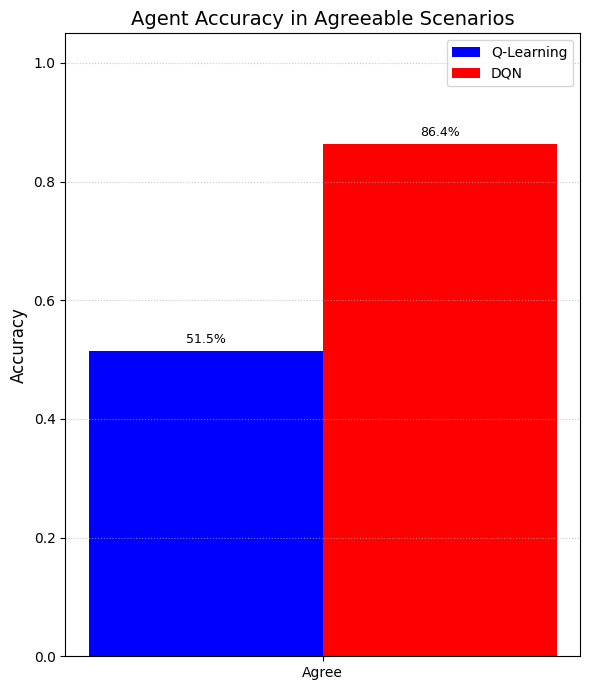


Analyzing Q-Learning conflict strategy...

Analyzing DQN conflict strategy...

Q-Learning Conflict Strategy: Followed Competency = 48.01%, Followed Reliability = 51.99% (Total Conflict Trials: 1504)
DQN Conflict Strategy: Followed Competency = 55.25%, Followed Reliability = 44.75% (Total Conflict Trials: 1504)


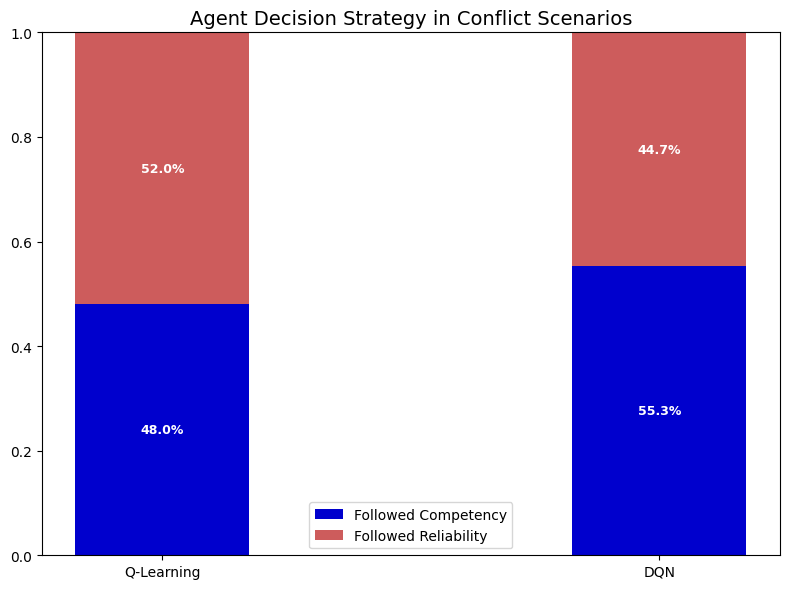

In [7]:
# --- Main Execution Block --- 
if __name__ == "__main__": 
    # Define the range of episodes you want to analyze 
    ANALYSIS_START_EPISODE = 1 
    ANALYSIS_END_EPISODE = 10 

    # --- Load logs for the original Q-Learning agent --- 
    print(f"Loading Q-Learning logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...") 
    q_learning_logs = load_q_learning_logs( 
        log_dir="train_log", # Your original Q-Learning log directory 
        start_episode=ANALYSIS_START_EPISODE, 
        end_episode=ANALYSIS_END_EPISODE 
    ) 
    print(f"Loaded Q-Learning logs for {len(q_learning_logs)} episodes.") 

    # --- Load logs for the DQN agent --- 
    print(f"Loading DQN logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...") 
    dqn_logs = load_dqn_logs( 
        log_dir="dqn_train_logs", # Your new DQN log directory 
        start_episode=ANALYSIS_START_EPISODE, 
        end_episode=ANALYSIS_END_EPISODE 
    ) 
    print(f"Loaded DQN logs for {len(dqn_logs)} episodes.") 

    # --- Analyze and Plot Agree Scenario Accuracy ---
    q_learning_accuracy_data = analyze_agent_strategy_accuracy(q_learning_logs, agent_type="Q-Learning")
    dqn_accuracy_data = analyze_agent_strategy_accuracy(dqn_logs, agent_type="DQN")

    print("\nQ-Learning Accuracy Data:")
    for scenario, (correct, total) in q_learning_accuracy_data.items():
        if total > 0:
            print(f"  {scenario}: Correct = {correct}, Total = {total}, Accuracy = {correct/total:.2%}")
        else:
            print(f"  {scenario}: No trials")

    print("\nDQN Accuracy Data:")
    for scenario, (correct, total) in dqn_accuracy_data.items():
        if total > 0:
            print(f"  {scenario}: Correct = {correct}, Total = {total}, Accuracy = {correct/total:.2%}")
        else:
            print(f"  {scenario}: No trials")

    # Plot accuracy for 'Agree' scenarios
    plot_strategy_accuracy(q_learning_accuracy_data, dqn_accuracy_data, filename="agree_scenario_accuracy.svg")


    # --- Analyze and Plot Conflict Strategy Proportions --- 
    print("\nAnalyzing Q-Learning conflict strategy...") 
    q_prop_comp, q_prop_rel, q_conflict_count = analyze_conflict_strategy(q_learning_logs, agent_type="Q-Learning") 
    
    print("\nAnalyzing DQN conflict strategy...") 
    dqn_prop_comp, dqn_prop_rel, dqn_conflict_count = analyze_conflict_strategy(dqn_logs, agent_type="DQN") 

    # Combine proportions and counts for plotting 
    q_learning_proportions = (q_prop_comp, q_prop_rel) 
    dqn_proportions = (dqn_prop_comp, dqn_prop_rel) 

    print(f"\nQ-Learning Conflict Strategy: Followed Competency = {q_prop_comp:.2%}, Followed Reliability = {q_prop_rel:.2%} (Total Conflict Trials: {q_conflict_count})")
    print(f"DQN Conflict Strategy: Followed Competency = {dqn_prop_comp:.2%}, Followed Reliability = {dqn_prop_rel:.2%} (Total Conflict Trials: {dqn_conflict_count})")

    plot_conflict_strategy_proportions(q_learning_proportions, dqn_proportions, q_conflict_count, dqn_conflict_count, filename="conflict_strategy_proportions.svg")

In [3]:
# --- Functions to Load Logs (unchanged from your provided code) --- 
def load_q_learning_logs(log_dir="train_log", start_episode=1, end_episode=10): 
    """ 
    Loads trial logs for the original Q-learning agent. 
    Assumes logs are lists of tuples: (state, action, reward, color, chosen_side) 
    """ 
    all_logs = {} 
    for ep_num in range(start_episode, end_episode + 1): 
        log_path = os.path.join(log_dir, f"episode{ep_num}_log.pkl") 
        if os.path.exists(log_path): 
            try: 
                with open(log_path, 'rb') as f: 
                    episode_data = pickle.load(f) 
                    if isinstance(episode_data, dict) and ep_num in episode_data: 
                        all_logs[ep_num] = episode_data.get(ep_num) 
                    else: 
                        all_logs[ep_num] = episode_data 
            except Exception as e: 
                print(f"Error loading Q-Learning log for episode {ep_num}: {e}") 
        else: 
            print(f"Q-Learning log file not found for episode {ep_num}: {log_path}") 
    return all_logs 

def load_dqn_logs(log_dir="dqn_train_logs", start_episode=1, end_episode=10): 
    """ 
    Loads trial logs for the DQN agent. 
    Assumes logs are lists of dictionaries: {'state': [...], 'action': ..., 'reward': ...} 
    """ 
    all_logs = {} 
    for ep_num in range(start_episode, end_episode + 1): 
        log_path = os.path.join(log_dir, f"dqn_episode{ep_num}_log.pkl") 
        if os.path.exists(log_path): 
            try: 
                with open(log_path, 'rb') as f: 
                    episode_data = pickle.load(f) 
                    all_logs[ep_num] = episode_data 
            except Exception as e: 
                print(f"Error loading DQN log for episode {ep_num}: {e}") 
        else: 
            print(f"DQN log file not found for episode {ep_num}: {log_path}") 
    return all_logs 

# --- Analyze Agent Accuracy by Strategy --- 
def analyze_agent_strategy_accuracy(all_agent_logs, agent_type="DQN", diff_epsilon=1e-3): 
    """ 
    Analyzes agent accuracy in three scenarios: 
    1. Agree: Competency and Reliability signals point to the same eel. 
    2. Conflict-FollowComp: Comp and Rel conflict, agent chose the eel favored by competency. 
    3. Conflict-FollowRel: Comp and Rel conflict, agent chose the eel favored by reliability. 

    Args: 
        all_agent_logs (dict): Dictionary of loaded episode logs for one agent type. 
        agent_type (str): "DQN" or "Q-Learning" to adjust log parsing. 
        diff_epsilon (float): Minimum absolute difference to consider a signal decisive. 

    Returns: 
        dict: A dictionary with 'agree', 'conflict_comp', 'conflict_rel' keys, 
              each mapping to a tuple (correct_count, total_count). 
    """ 
    is_dqn_log = (agent_type.lower() == "dqn") 

    scenario_data = { 
        'agree': {'correct': 0, 'total': 0}, 
        'conflict_comp': {'correct': 0, 'total': 0}, # For trials where agent followed competency in conflict 
        'conflict_rel': {'correct': 0, 'total': 0}   # For trials where agent followed reliability in conflict 
    } 

    logs_to_process = [] 
    if isinstance(all_agent_logs, dict): 
        for ep_num in sorted(all_agent_logs.keys()): 
            logs_to_process.extend(all_agent_logs.get(ep_num, [])) 
    elif isinstance(all_agent_logs, list): 
        logs_to_process = all_agent_logs 

    if not logs_to_process: 
        print(f"No logs to process for {agent_type}.") 
        return {k: (0, 0) for k in scenario_data.keys()} 

    for i, trial_data in enumerate(logs_to_process): 
        state_list = None 
        action = None # 0 for Left, 1 for Right 
        chosen_side_str = None 

        if is_dqn_log: 
            if not isinstance(trial_data, dict): continue 
            state_list = trial_data.get('state') 
            action = trial_data.get('action') 
            chosen_side_str = trial_data.get('chosen_side') 
        else: # Q-Learning 
            if not isinstance(trial_data, (tuple, list)) or len(trial_data) < 5: continue 
            state_list = trial_data[0] 
            action = trial_data[1] 
            chosen_side_str = trial_data[4] # 'left' or 'right' 

        if not isinstance(state_list, (tuple, list)) or len(state_list) != 4: continue 
        if action is None or chosen_side_str is None: continue # Ensure action and chosen_side are present 

        left_comp, left_rel, right_comp, right_rel = state_list 

        # Determine which side competency favors (ground truth for 'correct' choice) 
        comp_favors_left = left_comp > right_comp + diff_epsilon 
        comp_favors_right = right_comp > left_comp + diff_epsilon 
        comp_ambiguous = not comp_favors_left and not comp_favors_right 

        # Determine which side reliability favors 
        rel_favors_left = left_rel > right_rel + diff_epsilon 
        rel_favors_right = right_rel > left_rel + diff_epsilon 
        rel_ambiguous = not rel_favors_left and not rel_favors_right 

        # Determine agent's choice side based on action 
        agent_chose_left = (action == 0) 
        agent_chose_right = (action == 1) 

        # Skip trials where competency is ambiguous, as we define 'correctness' based on competency 
        if comp_ambiguous: 
            continue 

        # Determine the 'correct' side based on competency (ground truth) 
        correct_side = 'left' if comp_favors_left else 'right' 
        agent_chose_correctly = (agent_chose_left and correct_side == 'left') or \
                                (agent_chose_right and correct_side == 'right') 

        # --- Classify the trial and update counts --- 
        if (comp_favors_left and rel_favors_left) or (comp_favors_right and rel_favors_right): 
            # Agree scenario: Comp and Rel point to the same side 
            if not rel_ambiguous: # Only if reliability also has a clear signal 
                scenario_data['agree']['total'] += 1 
                if agent_chose_correctly: 
                    scenario_data['agree']['correct'] += 1 
        elif (comp_favors_left and rel_favors_right) or \
             (comp_favors_right and rel_favors_left): 
            # Conflict scenario: Comp and Rel point to different sides 
            if rel_ambiguous: # Skip if reliability is ambiguous even in conflict 
                continue 

            # Check if agent followed competency 
            if (agent_chose_left and comp_favors_left) or (agent_chose_right and comp_favors_right): 
                scenario_data['conflict_comp']['total'] += 1 
                if agent_chose_correctly: # Agent chose comp's favored side, which is the correct side 
                    scenario_data['conflict_comp']['correct'] += 1 
            # Check if agent followed reliability 
            elif (agent_chose_left and rel_favors_left) or (agent_chose_right and rel_favors_right): 
                scenario_data['conflict_rel']['total'] += 1 
                if agent_chose_correctly: # Agent chose rel's favored side, check if it was correct (i.e., coincided with competency) 
                    scenario_data['conflict_rel']['correct'] += 1 

    # Convert counts to (correct_count, total_count) tuples for consistency 
    return {k: (v['correct'], v['total']) for k, v in scenario_data.items()} 

# --- Plotting Function for Strategy Accuracy (First Plot - adjusted for 'Agree' only) --- 
def plot_strategy_accuracy(q_learning_accuracy_data, dqn_accuracy_data, filename="agree_scenario_accuracy.svg"): 
    """ 
    Plots the accuracy of Q-Learning and DQN agents specifically for the 'Agree' scenario. 
    Saves the plot as an SVG file. 

    Args: 
        q_learning_accuracy_data (dict): Accuracy data for Q-Learning. 
        dqn_accuracy_data (dict): Accuracy data for DQN. 
        filename (str): Name of the file to save the plot. 
    """ 
    labels = ['Agree'] 

    q_learning_accuracy = q_learning_accuracy_data['agree'][0] / max(1, q_learning_accuracy_data['agree'][1]) 
    dqn_accuracy = dqn_accuracy_data['agree'][0] / max(1, dqn_accuracy_data['agree'][1]) 

    # Handle cases where total trials are zero for a category for display 
    q_learning_display_accuracy = f'{q_learning_accuracy:.1%}' if q_learning_accuracy_data['agree'][1] > 0 else 'N/A' 
    dqn_display_accuracy = f'{dqn_accuracy:.1%}' if dqn_accuracy_data['agree'][1] > 0 else 'N/A' 

    x = np.arange(len(labels)) 
    width = 0.35 

    fig, ax = plt.subplots(figsize=(6, 7)) # Adjusted figure size for single bar group 
    rects1 = ax.bar(x - width/2, [q_learning_accuracy], width, label='Q-Learning', color='blue') 
    rects2 = ax.bar(x + width/2, [dqn_accuracy], width, label='DQN', color='red') 

    ax.set_ylabel('Accuracy', fontsize=12) 
    ax.set_title('Agent Accuracy in Agreeable Scenarios', fontsize=14) 
    ax.set_xticks(x) 
    ax.set_xticklabels(labels, fontsize=10) 
    ax.set_ylim(0, 1.05) 
    ax.legend(fontsize=10) 
    ax.grid(axis='y', linestyle=':', alpha=0.7) 

    # Add accuracy labels on top of bars 
    def autolabel(rects, display_texts): 
        for rect, text in zip(rects, display_texts): 
            height = rect.get_height() 
            ax.annotate(text, 
                        xy=(rect.get_x() + rect.get_width() / 2, height), 
                        xytext=(0, 3),  # 3 points vertical offset 
                        textcoords="offset points", 
                        ha='center', va='bottom', fontsize=9, color='black') 

    autolabel(rects1, [q_learning_display_accuracy]) 
    autolabel(rects2, [dqn_display_accuracy]) 

    plt.tight_layout() 
    plt.savefig(filename, format='svg') # Save the plot as SVG
    plt.show() 
    plt.close() 

# --- Function to Analyze Conflict Strategy Proportions --- 
def analyze_conflict_strategy(all_agent_logs, agent_type="DQN"): 
    """ 
    Analyzes how an agent makes choices when competency and reliability signals conflict. 

    Args: 
        all_agent_logs (dict): Dictionary of loaded episode logs for one agent type. 
        agent_type (str): "DQN" or "Q-Learning" to adjust log parsing. 

    Returns: 
        tuple: (proportion_followed_comp, proportion_followed_rel, total_conflict_trials) 
    """ 
    is_dqn_log = (agent_type.lower() == "dqn") 

    followed_competency_count = 0 
    followed_reliability_count = 0 
    total_conflict_trials = 0 

    logs_to_process_prop = [] 
    if isinstance(all_agent_logs, dict): 
        for ep_num in sorted(all_agent_logs.keys()): 
            logs_to_process_prop.extend(all_agent_logs.get(ep_num, [])) 
    elif isinstance(all_agent_logs, list): 
        logs_to_process_prop = all_agent_logs 
    
    if not logs_to_process_prop: 
        print(f"No logs to process for {agent_type} conflict strategy analysis.") 
        return 0, 0, 0 

    for trial_data in logs_to_process_prop: 
        state_list = None 
        action = None 

        if is_dqn_log: 
            if not isinstance(trial_data, dict): continue 
            state_list = trial_data.get('state') 
            action = trial_data.get('action') 
        else: 
            if not isinstance(trial_data, (tuple, list)) or len(trial_data) < 5: continue 
            state_list = trial_data[0] 
            action = trial_data[1] 

        if not isinstance(state_list, (tuple, list)) or len(state_list) != 4: continue 
        if action is None: continue 

        left_comp, left_rel, right_comp, right_rel = state_list 

        epsilon = 1e-3 # Consistent epsilon 
        comp_favors_left = left_comp > right_comp + epsilon 
        comp_favors_right = right_comp > left_comp + epsilon # Corrected comparison 
        rel_favors_left = left_rel > right_rel + epsilon 
        rel_favors_right = right_rel > left_rel + epsilon # Corrected comparison 

        is_conflict = False 
        if (comp_favors_left and rel_favors_right) or \
           (comp_favors_right and rel_favors_left): 
            is_conflict = True 

        if is_conflict: 
            total_conflict_trials += 1 
            agent_chose_left = (action == 0) 
            agent_chose_right = (action == 1) 

            if comp_favors_left and rel_favors_right: 
                if agent_chose_left: 
                    followed_competency_count += 1 
                elif agent_chose_right: 
                    followed_reliability_count += 1 
            elif comp_favors_right and rel_favors_left: 
                if agent_chose_left: 
                    followed_reliability_count += 1 
                elif agent_chose_right: 
                    followed_competency_count += 1 
    
    if total_conflict_trials == 0: 
        print(f"No clear conflict trials found for {agent_type} agent for proportion analysis.") 
        return 0, 0, 0 

    prop_followed_comp = followed_competency_count / total_conflict_trials 
    prop_followed_rel = followed_reliability_count / total_conflict_trials 
    
    return prop_followed_comp, prop_followed_rel, total_conflict_trials 

# --- Plotting Function for Conflict Strategy Proportions (Reverted to your previous code) --- 
def plot_conflict_strategy_proportions(q_learning_props, dqn_props, q_learning_count, dqn_count, filename="conflict_strategy_proportions.svg"): 
    """ 
    Plots a bar chart showing the proportion of times Q-Learning and DQN agents 
    followed competency vs. reliability in conflict scenarios. 
    Saves the plot as an SVG file.
    """ 
    labels = ['Q-Learning', 'DQN'] 
    comp_proportions = [q_learning_props[0], dqn_props[0]] 
    rel_proportions = [q_learning_props[1], dqn_props[1]] 

    # Bar width 
    width = 0.35 

    fig, ax = plt.subplots(figsize=(8, 6)) 

    # Stacked bars 
    # 'bottom' argument ensures the bars stack correctly 
    comp_bars = ax.bar(labels, comp_proportions, width, label='Followed Competency', color='mediumblue') 
    rel_bars = ax.bar(labels, rel_proportions, width, bottom=comp_proportions, label='Followed Reliability', color='indianred') 

    ax.set_title('Agent Decision Strategy in Conflict Scenarios', fontsize=14) 
    ax.set_ylim(0, 1) # Proportions go from 0 to 1 
    ax.legend(fontsize=10) 

    # Add percentage labels inside the bars 
    for r1, r2 in zip(comp_bars, rel_bars): 
        h1 = r1.get_height() 
        h2 = r2.get_height() 
        if h1 > 0: 
            ax.text(r1.get_x() + r1.get_width() / 2, h1 / 2, f'{h1:.1%}', ha='center', va='center', color='white', fontsize=9, weight='bold') 
        if h2 > 0: 
            ax.text(r2.get_x() + r2.get_width() / 2, h1 + h2 / 2, f'{h2:.1%}', ha='center', va='center', color='white', fontsize=9, weight='bold') 

    plt.tight_layout() 
    plt.savefig(filename, format='svg') # Save the plot as SVG
    plt.show() 
    plt.close() 

# --- New Function to Analyze Integration Strategy (Simplified) ---
def analyze_integration_strategy(all_agent_logs, agent_type="DQN"):
    """
    Analyzes whether an agent's choices align more with an additive or multiplicative
    integration of competency and reliability, specifically in trials where these
    two models disagree on the optimal choice. The 'neither' category is removed,
    as the agent must choose one in conflict trials.

    Args:
        all_agent_logs (dict): Dictionary of loaded episode logs for one agent type.
        agent_type (str): "DQN" or "Q-Learning" to adjust log parsing.

    Returns:
        tuple: (proportion_followed_additive, proportion_followed_multiplicative, total_relevant_trials)
               or (0, 0, 0) if no relevant trials found.
    """
    is_dqn_log = (agent_type.lower() == "dqn")

    followed_additive_count = 0
    followed_multiplicative_count = 0
    total_relevant_trials = 0 # Trials where additive and multiplicative models disagree

    # A small epsilon for floating point comparisons to handle near-zero differences or ties
    epsilon = 1e-9 

    logs_to_process_integration = []
    if isinstance(all_agent_logs, dict):
        for ep_num in sorted(all_agent_logs.keys()):
            logs_to_process_integration.extend(all_agent_logs.get(ep_num, []))
    elif isinstance(all_agent_logs, list):
        logs_to_process_integration = all_agent_logs

    if not logs_to_process_integration:
        print(f"No logs to process for {agent_type} integration strategy analysis.")
        return 0, 0, 0

    for trial_data in logs_to_process_integration:
        if is_dqn_log:
            state_list = trial_data.get('state')
            agent_action = trial_data.get('action') # 0 for Left, 1 for Right
        else:
            if not isinstance(trial_data, (tuple, list)) or len(trial_data) < 5: continue
            state_list = trial_data[0]
            agent_action = trial_data[1] # 0 for Left, 1 for Right

        if not isinstance(state_list, (tuple, list)) or len(state_list) != 4: continue
        if agent_action is None: continue

        left_comp, left_rel, right_comp, right_rel = state_list

        # Calculate additive and multiplicative values for each eel
        left_add_val = left_comp + left_rel
        right_add_val = right_comp + right_rel
        left_mult_val = left_comp * left_rel
        right_mult_val = right_comp * right_rel

        # Determine optimal choice according to each model, handling ties with epsilon
        add_optimal_choice = None
        if left_add_val > right_add_val + epsilon:
            add_optimal_choice = 0 # Left
        elif right_add_val > left_add_val + epsilon:
            add_optimal_choice = 1 # Right

        mult_optimal_choice = None
        if left_mult_val > right_mult_val + epsilon:
            mult_optimal_choice = 0 # Left
        elif right_mult_val > left_mult_val + epsilon:
            mult_optimal_choice = 1 # Right

        # Analyze only if both models have a distinct optimal choice AND they disagree
        if add_optimal_choice is not None and mult_optimal_choice is not None and \
           add_optimal_choice != mult_optimal_choice:
            
            total_relevant_trials += 1
            
            # Agent must choose one of the two predictions if they conflict
            if agent_action == add_optimal_choice:
                followed_additive_count += 1
            elif agent_action == mult_optimal_choice:
                followed_multiplicative_count += 1
            # No 'neither' here, as agent_action must be 0 or 1, matching one of the distinct optimal choices
    
    if total_relevant_trials == 0:
        print(f"No trials found where additive and multiplicative models had distinct and conflicting optimal predictions for {agent_type} agent.")
        return 0, 0, 0 # prop_add, prop_mult, total_count

    prop_followed_additive = followed_additive_count / total_relevant_trials
    prop_followed_multiplicative = followed_multiplicative_count / total_relevant_trials
    
    return prop_followed_additive, prop_followed_multiplicative, total_relevant_trials

# --- New Function to Plot Integration Strategy Proportions (Simplified) ---
def plot_integration_strategy_proportions(q_learning_results, dqn_results, filename="integration_strategy_proportions.svg"):
    """
    Plots a stacked bar chart showing the proportion of times Q-Learning and DQN agents
    followed additive vs. multiplicative models in trials where these models disagreed.
    The 'neither' category is excluded.
    Saves the plot as an SVG file.
    """
    labels = ['Q-Learning', 'DQN']
    
    q_add_prop, q_mult_prop, q_total_count = q_learning_results
    dqn_add_prop, dqn_mult_prop, dqn_total_count = dqn_results

    add_proportions = [q_add_prop, dqn_add_prop]
    mult_proportions = [q_mult_prop, dqn_mult_prop]
    
    fig, ax = plt.subplots(figsize=(8, 6))

    # Stacked bars
    bar_add = ax.bar(labels, add_proportions, width=0.4, label='Followed Additive Model', color='mediumblue')
    bar_mult = ax.bar(labels, mult_proportions, width=0.4, bottom=add_proportions, label='Followed Multiplicative Model', color='indianred')
    
    ax.set_ylabel('Proportion of Disagreement Trials', fontsize=12) # Changed y-axis label for clarity
    ax.set_title('Agent Decision Strategy: Additive vs. Multiplicative Integration', fontsize=14)
    ax.set_ylim(0, 1) # Proportions go from 0 to 1
    ax.legend(fontsize=10)

    # Add percentage labels inside the bars
    for r1, r2 in zip(bar_add, bar_mult):
        h1 = r1.get_height()
        h2 = r2.get_height()

        if h1 > 0:
            ax.text(r1.get_x() + r1.get_width() / 2, h1 / 2, f'{h1:.1%}', ha='center', va='center', color='white', fontsize=9, weight='bold')
        if h2 > 0:
            ax.text(r2.get_x() + r2.get_width() / 2, h1 + h2 / 2, f'{h2:.1%}', ha='center', va='center', color='white', fontsize=9, weight='bold')

    plt.tight_layout()
    plt.savefig(filename, format='svg') # Save the plot as SVG
    plt.show()
    plt.close()

Loading Q-Learning logs from episode 1 to 10...
Loaded Q-Learning logs for 10 episodes.
Loading DQN logs from episode 1 to 10...
Loaded DQN logs for 10 episodes.

Q-Learning Accuracy Data:
  agree: Correct = 771, Total = 1496, Accuracy = 51.54%
  conflict_comp: Correct = 722, Total = 722, Accuracy = 100.00%
  conflict_rel: Correct = 0, Total = 782, Accuracy = 0.00%

DQN Accuracy Data:
  agree: Correct = 1293, Total = 1496, Accuracy = 86.43%
  conflict_comp: Correct = 831, Total = 831, Accuracy = 100.00%
  conflict_rel: Correct = 0, Total = 673, Accuracy = 0.00%


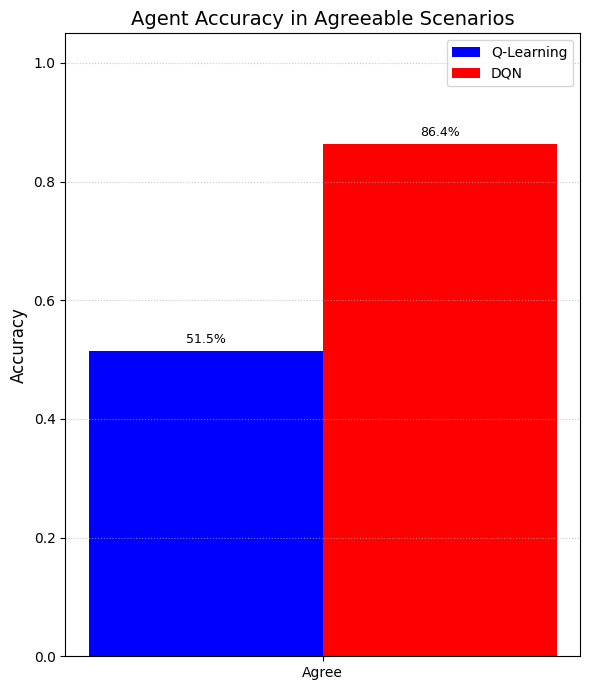


Analyzing Q-Learning conflict strategy...

Analyzing DQN conflict strategy...

Q-Learning Conflict Strategy: Followed Competency = 48.01%, Followed Reliability = 51.99% (Total Conflict Trials: 1504)
DQN Conflict Strategy: Followed Competency = 55.25%, Followed Reliability = 44.75% (Total Conflict Trials: 1504)


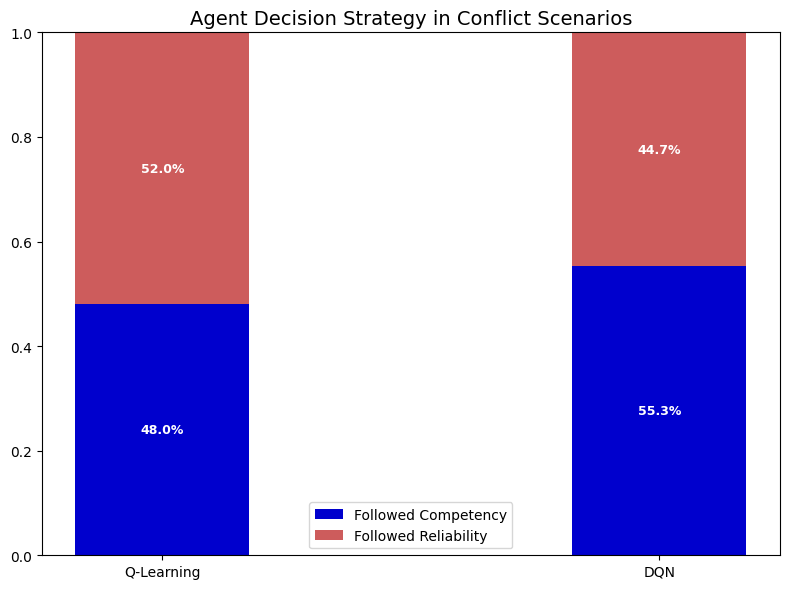


Analyzing Q-Learning integration strategy...
Q-Learning Integration Strategy: Followed Additive = 47.80%, Followed Multiplicative = 52.20% (Total Relevant Trials: 1044)

Analyzing DQN integration strategy...
DQN Integration Strategy: Followed Additive = 58.44%, Followed Multiplicative = 41.56% (Total Relevant Trials: 1273)


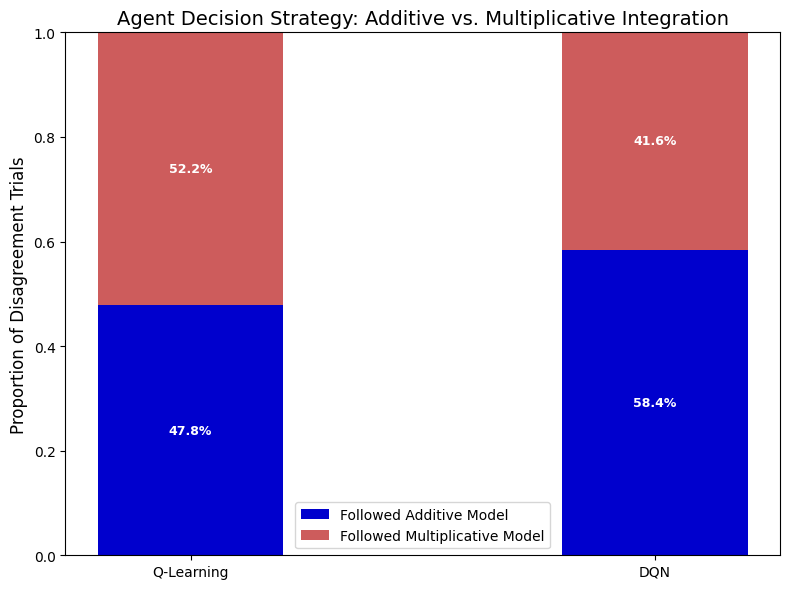

In [4]:
# --- Main Execution Block --- 
if __name__ == "__main__": 
    # Define the range of episodes you want to analyze 
    ANALYSIS_START_EPISODE = 1 
    ANALYSIS_END_EPISODE = 10
    # --- Load logs for the original Q-Learning agent --- 
    print(f"Loading Q-Learning logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...") 
    q_learning_logs = load_q_learning_logs( 
        log_dir="train_log", # Your original Q-Learning log directory 
        start_episode=ANALYSIS_START_EPISODE, 
        end_episode=ANALYSIS_END_EPISODE 
    ) 
    print(f"Loaded Q-Learning logs for {len(q_learning_logs)} episodes.") 

    # --- Load logs for the DQN agent --- 
    print(f"Loading DQN logs from episode {ANALYSIS_START_EPISODE} to {ANALYSIS_END_EPISODE}...") 
    dqn_logs = load_dqn_logs( 
        log_dir="dqn_train_logs", # Your new DQN log directory 
        start_episode=ANALYSIS_START_EPISODE, 
        end_episode=ANALYSIS_END_EPISODE 
    ) 
    print(f"Loaded DQN logs for {len(dqn_logs)} episodes.") 

    # --- Analyze and Plot Agree Scenario Accuracy ---
    q_learning_accuracy_data = analyze_agent_strategy_accuracy(q_learning_logs, agent_type="Q-Learning")
    dqn_accuracy_data = analyze_agent_strategy_accuracy(dqn_logs, agent_type="DQN")

    print("\nQ-Learning Accuracy Data:")
    for scenario, (correct, total) in q_learning_accuracy_data.items():
        if total > 0:
            print(f"  {scenario}: Correct = {correct}, Total = {total}, Accuracy = {correct/total:.2%}")
        else:
            print(f"  {scenario}: No trials")

    print("\nDQN Accuracy Data:")
    for scenario, (correct, total) in dqn_accuracy_data.items():
        if total > 0:
            print(f"  {scenario}: Correct = {correct}, Total = {total}, Accuracy = {correct/total:.2%}")
        else:
            print(f"  {scenario}: No trials")

    # Plot accuracy for 'Agree' scenarios
    plot_strategy_accuracy(q_learning_accuracy_data, dqn_accuracy_data, filename="agree_scenario_accuracy.svg")


    # --- Analyze and Plot Conflict Strategy Proportions --- 
    print("\nAnalyzing Q-Learning conflict strategy...") 
    q_prop_comp, q_prop_rel, q_conflict_count = analyze_conflict_strategy(q_learning_logs, agent_type="Q-Learning") 
    
    print("\nAnalyzing DQN conflict strategy...") 
    dqn_prop_comp, dqn_prop_rel, dqn_conflict_count = analyze_conflict_strategy(dqn_logs, agent_type="DQN") 

    # Combine proportions and counts for plotting 
    q_learning_proportions = (q_prop_comp, q_prop_rel) 
    dqn_proportions = (dqn_prop_comp, dqn_prop_rel) 

    print(f"\nQ-Learning Conflict Strategy: Followed Competency = {q_prop_comp:.2%}, Followed Reliability = {q_prop_rel:.2%} (Total Conflict Trials: {q_conflict_count})")
    print(f"DQN Conflict Strategy: Followed Competency = {dqn_prop_comp:.2%}, Followed Reliability = {dqn_prop_rel:.2%} (Total Conflict Trials: {dqn_conflict_count})")

    plot_conflict_strategy_proportions(q_learning_proportions, dqn_proportions, q_conflict_count, dqn_conflict_count, filename="conflict_strategy_proportions.svg")

    # --- Analyze and Plot Integration Strategy ---
    print("\nAnalyzing Q-Learning integration strategy...")
    q_learning_integration_results = analyze_integration_strategy(q_learning_logs, agent_type="Q-Learning")
    print(f"Q-Learning Integration Strategy: Followed Additive = {q_learning_integration_results[0]:.2%}, Followed Multiplicative = {q_learning_integration_results[1]:.2%} (Total Relevant Trials: {q_learning_integration_results[2]})")

    print("\nAnalyzing DQN integration strategy...")
    dqn_integration_results = analyze_integration_strategy(dqn_logs, agent_type="DQN")
    print(f"DQN Integration Strategy: Followed Additive = {dqn_integration_results[0]:.2%}, Followed Multiplicative = {dqn_integration_results[1]:.2%} (Total Relevant Trials: {dqn_integration_results[2]})")

    plot_integration_strategy_proportions(q_learning_integration_results, dqn_integration_results, filename="integration_strategy_proportions.svg")